#### From https://github.com/chenyuntc/pytorch-book.git

#### 數據加載與預處理

在深度學習中數據加載及預處理是非常複雜繁瑣的，但PyTorch提供了一些可極大簡化和加快數據處理流程的工具。同時，對於常用的數據集，PyTorch也提供了封裝好的接口供用戶快速調用，這些數據集主要保存在torchvison中。

`torchvision`實現了常用的圖像數據加載功能，例如Imagenet、CIFAR10、MNIST等，以及常用的數據轉換操作，這極大地方便了數據加載，並且代碼具有可重用性。


### Try: CIFAR-10分類

下面我們來嘗試實現對CIFAR-10數據集的分類，步驟如下:

1. 使用torchvision加載並預處理CIFAR-10數據集
2. 定義網絡
3. 定義損失函數和優化器
4. 訓練網絡並更新網絡參數
5. 測試網絡

#### CIFAR-10數據加載及預處理

CIFAR-10[*]是一個常用的彩色圖片數據集，它有10個類別: 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'。每張圖片都是$3\times32\times32$，也即3-通道彩色圖片，分辨率為$32\times32$。

[*]: http://www.cs.toronto.edu/~kriz/cifar.html

In [1]:
from __future__ import print_function
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision as tv
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
show = ToPILImage() # 可以把Tensor轉成Image，方便可視化

In [2]:
transform = transforms.Compose([
        transforms.ToTensor(), # 轉為Tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # 歸一化
                             ])
transform

Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)

#### Dataset

In [3]:
# Training Set
trainset = tv.datasets.CIFAR10(
                    root='/d/tmp/data/',
                    train=True, 
                    download=True,
                    transform=transform)

trainloader = t.utils.data.DataLoader(
                    trainset, 
                    batch_size=4,
                    shuffle=True, 
                    num_workers=2)

# Testing Set
testset = tv.datasets.CIFAR10(
                    '/d/tmp/data/', 
                    train=False, 
                    download=True, 
                    transform=transform)

testloader = t.utils.data.DataLoader(
                    testset,
                    batch_size=4, 
                    shuffle=False,
                    num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
(data, label) = trainset[100]

In [5]:
print(data)

tensor([[[0.6706, 0.6549, 0.6549,  ..., 0.1843, 0.1843, 0.1686],
         [0.6784, 0.6627, 0.6627,  ..., 0.1922, 0.1922, 0.1843],
         [0.6941, 0.6784, 0.6706,  ..., 0.2000, 0.2000, 0.1843],
         ...,
         [0.1373, 0.0667, 0.1216,  ..., 0.6941, 0.5373, 0.4353],
         [0.0902, 0.0118, 0.0118,  ..., 0.7804, 0.7490, 0.6392],
         [0.0745, 0.1216, 0.0667,  ..., 0.6392, 0.7020, 0.7882]],

        [[0.7961, 0.7804, 0.7804,  ..., 0.3647, 0.3647, 0.3490],
         [0.7961, 0.7804, 0.7804,  ..., 0.3725, 0.3725, 0.3647],
         [0.7961, 0.7804, 0.7804,  ..., 0.3804, 0.3804, 0.3647],
         ...,
         [0.2471, 0.1608, 0.1922,  ..., 0.7020, 0.5451, 0.4353],
         [0.2000, 0.1137, 0.0902,  ..., 0.7882, 0.7569, 0.6392],
         [0.1922, 0.2157, 0.1373,  ..., 0.6392, 0.7020, 0.7882]],

        [[0.8980, 0.8824, 0.8824,  ..., 0.6157, 0.6157, 0.6000],
         [0.8902, 0.8745, 0.8745,  ..., 0.6235, 0.6235, 0.6078],
         [0.8745, 0.8588, 0.8588,  ..., 0.6157, 0.6157, 0.

In [6]:
print(label)

8


ship


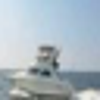

In [7]:
print(classes[label])
# (data + 1) / 2是為了還原被歸一化的數據
show((data + 1) / 2).resize((100, 100))

        car        ship        frog        ship


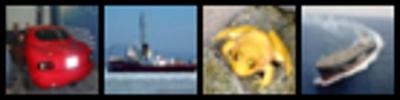

In [8]:
dataiter = iter(trainloader)
images, labels = dataiter.next() # 返回4張圖片及標籤
print(' '.join('%11s'%classes[labels[j]] for j in range(4)))
show(tv.utils.make_grid((images+1)/2)).resize((400,100))

## Define Network
Also Use LeNet, change the first parameter of "self.conv1" to 3
since CIFAR-10 is an 3 channel picture"

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) 
        self.conv2 = nn.Conv2d(6, 16, 5)  
        self.fc1   = nn.Linear(16*5*5, 120)  
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x): 
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) 
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) 
        x = x.view(x.size()[0], -1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)        
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### Define Loss Function and Optimizer

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Train the Network

In [11]:
t.set_num_threads(8)

for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        inputs, labels = data
        optimizer.zero_grad()
        
        # Forward + Backward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Tuning the parameter
        optimizer.step()
        #loss is a scalar,We need to use loss.item() to get the value instead of using loss[0]
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.206
[1,  4000] loss: 1.896
[1,  6000] loss: 1.694
[1,  8000] loss: 1.594
[1, 10000] loss: 1.516
[1, 12000] loss: 1.457
[2,  2000] loss: 1.381
[2,  4000] loss: 1.354
[2,  6000] loss: 1.319
[2,  8000] loss: 1.293
[2, 10000] loss: 1.277
[2, 12000] loss: 1.277
Finished Training


此處僅訓練了2個epoch（遍歷完一遍數據集稱為一個epoch），來看看網絡有沒有效果。將測試圖片輸入到網絡中，計算它的label，然後與實際的label進行比較。

Real label:       cat     ship     ship    plane


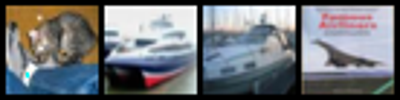

In [12]:
dataiter = iter(testloader)
images, labels = dataiter.next() # 一個batch返回4張圖片
print('Real label: ', ' '.join(\
            '%08s'%classes[labels[j]] for j in range(4)))
show(tv.utils.make_grid(images / 2 - 0.5)).resize((400,100))

In [13]:
# Look at the Predict
outputs = net(images)
# Get the label that has the highest score
_, predicted = t.max(outputs.data, 1)

print('Predicted label: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted label:    cat plane plane plane


In [14]:
correct = 0 
total = 0 

# 由於測試的時候不需要求導，可以暫時關閉autograd，提高速度，節約內存
with t.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = t.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

print('10000張測試集中的準確率為: %d %%' % (100 * correct / total))

10000張測試集中的準確率為: 55 %


..\aten\src\ATen\native\BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


### If we want to use GPU

In [16]:
device = t.device("cuda:0" if t.cuda.is_available() else "cpu")

net.to(device)
images = images.to(device)
labels = labels.to(device)
output = net(images)
loss= criterion(output,labels)

loss

tensor(0.2068, device='cuda:0', grad_fn=<NllLossBackward>)